In [36]:
from Bio import SeqIO, Entrez
import os
from urllib.error import HTTPError
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import permutations, product
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
import tqdm
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score

from numpy import mean
from numpy import std
import pickle
from os import path
from sklearn.model_selection import cross_val_score
from warnings import simplefilter
from collections import OrderedDict
from sklearn.metrics import accuracy_score, auc, confusion_matrix, balanced_accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score

from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)

Entrez.tool = "Zoonosis predictor"

Entrez.email = input("Enter an email address to use NCBI e-utils: ")


In [90]:
def resetkmerdict(permset)->OrderedDict:
        kmerdict = OrderedDict()
        for i in permset:
            kmerdict[i]=0
        return kmerdict

def assign_kmers_to_dict(st, permset, kmer):
    kmerdict=resetkmerdict(permset)
    # st = row[2] # tune for which column the sequence is in
    for j in range(len(st)-kmer+1):
        if not st[j:j+kmer] in permset: continue
        kmerdict[st[j:j+kmer]]+=1
    return kmerdict

def getTrainParams(mergedDf):
    kmer = 4

    s = product('acgt',repeat = kmer)
    permset = set(["".join(x) for x in list(s)])
    # print(permset)

    l = []
    
    for row in tqdm.tqdm(mergedDf.itertuples()):
        # print(row)
        l.append(assign_kmers_to_dict(row[2], permset, kmer))
    

    finalkmerdict=pd.DataFrame(l)
    # print(finalkmerdict)

    # print("finished")
    mergedDf.fillna(0, inplace=True)

    X = finalkmerdict
    Y = mergedDf['isZoonotic']

    # print(X)
    # print(Y)
    return train_test_split(X, Y, test_size=0.2, random_state=1)

In [11]:
def queryKmer(ID, isZoonotic_list, index, everything):
    try:
        QueryHandle = Entrez.efetch(db="nucleotide", id=ID, 
                                    rettype="gb", retmode="text")
    except HTTPError as Error:
        if Error.code == 400:  # Bad request
            raise ValueError(f"Accession number not found: {ID}")
        else:
            raise

    SeqRec = SeqIO.read(QueryHandle, "genbank")
    # print(str(SeqRec.seq))
    everything.append({'accession': ID, 'sequence': str(SeqRec.seq).lower(), 'isZoonotic': isZoonotic_list[index]})
    

In [91]:
def getSequences(mergedDf):
    accession_list = [] # maintain order
    isZoonotic_list = [] # maintain order
    accession_set = set()
    isZoonotic_set = set()


    for row in tqdm.tqdm(mergedDf.itertuples()):
        # row[13] = accession, row[15] = infects humans
        for single_acc in row[14].split("; "):
            if single_acc not in accession_set:
                accession_list.append(single_acc)
                isZoonotic_list.append(row[15])
                accession_set.add(single_acc)
                isZoonotic_set.add(row[15])


    # TODO: RUN MULTIPLE THREADS TO SPEED UP
    threads = []
    vals = []
    
    for index, ID in enumerate(tqdm.tqdm(accession_list[:100])): #only read the first 100 lol
        # multithread for speed up
        queryKmer(ID, isZoonotic_list, index, vals)
        # x = threading.Thread(target=queryKmer, args=(ID, isZoonotic_list, index, vals))
        # threads.append(x)
        # x.start()

    # for index, thread in enumerate(tqdm.tqdm(threads)):
    #     thread.join()
    df = pd.DataFrame(vals)

    return df
    


In [92]:
mergedDf = pd.read_csv("FinalData_Cleaned.csv") # read mollentze data
sequences = getSequences(mergedDf)
X_train, X_test, y_train, y_test = getTrainParams(sequences)

913it [00:00, 664480.23it/s]
100%|██████████| 100/100 [00:43<00:00,  2.30it/s]
100it [00:00, 316.59it/s]


In [22]:
best_gradBoost = pickle.load(open('curr_models/gradBoost.pkl', 'rb'))
best_xgBoost = pickle.load(open('curr_models/xgBoost.pkl', 'rb'))
kmer = 4
print(sequences)

s = product('acgt',repeat = kmer)
permset = set(["".join(x) for x in list(s)])

pred_arr = []
xg_pred = []
for ind, file in enumerate(os.listdir("./virome_contigs")):
    fasta_sequences = SeqIO.parse(open(f"./virome_contigs/{file}"),'fasta')

    fasta = [x for x in fasta_sequences][0]
    # print(fasta)
    
    name, sequence = fasta.id, str(fasta.seq)
    X_info = sequence.lower()

    oDict = assign_kmers_to_dict(X_info, permset, kmer) # convert ordereddict to pandas dataframe

    kmer_df = pd.DataFrame()

    for i in oDict:
        kmer_df.at[0, i]=oDict[i]
    cols_when_model_builds = best_gradBoost.feature_names_in_
    kmer_df=kmer_df[cols_when_model_builds]
    
    pred_arr.append(best_gradBoost.predict(kmer_df))
    
    cols_when_model_builds = best_xgBoost.get_booster().feature_names
    kmer_df=kmer_df[cols_when_model_builds]

    xg_pred.append(best_xgBoost.predict(kmer_df))


    
pred_arr = np.asarray(pred_arr)
xg_pred = np.asarray(xg_pred)


    # print(best_gradBoost.predict(kmer_df), sequences.loc[ind]['isZoonotic'])
    # print(best_gradBoost.predict(kmer_df), sequences['isZoonotic'])
        # print(accuracy_score())

print(sequences['isZoonotic'][sequences['isZoonotic'] == 1].to_numpy())
print(len(sequences['isZoonotic'][sequences['isZoonotic'] == 1].to_numpy()))
print(xg_pred.sum())
print(pred_arr.sum())


    # with open(output_file) as out_file:
    #     for fasta in fasta_sequences:
    #         name, sequence = fasta.id, str(fasta.seq)
    #         new_sequence = some_function(sequence)
    #         write_fasta(out_file)

      accession                                           sequence  isZoonotic
0   NC_025403.1  accagagggaaaatataacaatgtcgttttatagcgatgtaaataa...           1
1   NC_025404.1  accagagggaaaattaagaaaggtcgttccaagacgacttaaaaga...           1
2   NC_028246.1  acggagaaaaacaaaaaaactatagtgattagataaataaggaaaa...           1
3   NC_002077.1  ttgcccactccctctctgcgcgctcgctcgctcggtggggcctgcg...           1
4   NC_006152.1  ctctcccccctgtcgcgttcgctcgctcgctggctcgtttgggggg...           1
..          ...                                                ...         ...
95  NC_004218.1  gtattaaatttttgtaagtcgttatggaattatttagtgacagtgg...           1
96  NC_004219.1  gtatttaaaattcatgtttttgcatcatggcgtgggttacgcaagc...           1
97  NC_004220.1  gtattaaaaattacaagaacctaacattgcaatggagatcttgaga...           1
98  NC_004221.1  gtatttaaaattatagaaagttctgaacctaggggtctttctgtct...           1
99  NC_004204.1  gtattaaaattcagcaattgtccaatttaggaaacattctgtttaa...           1

[100 rows x 3 columns]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [20]:
print(accuracy_score(sequences['isZoonotic'], pred_arr[:100]))
print(accuracy_score(sequences['isZoonotic'], xg_pred[:100]))

0.33
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
0.07


In [42]:
def getSingleSequence(accessionID):
    try:
        QueryHandle = Entrez.efetch(db="nucleotide", id=accessionID, 
                                    rettype="gb", retmode="text")
    except HTTPError as Error:
        if Error.code == 400:  # Bad request
            raise ValueError(f"Accession number not found: {accessionID}")
        else:
            raise

    SeqRec = SeqIO.read(QueryHandle, "genbank")
    print(str(SeqRec))

    oDict = assign_kmers_to_dict(X_info, permset, kmer) # convert ordereddict to pandas dataframe

    kmer_df = pd.DataFrame()

    for i in oDict:
        kmer_df.at[0, i]=oDict[i]
    # print(best_gradBoost.predict_proba(kmer_df))

    cols_when_model_builds = best_gradBoost.feature_names_in_
    kmer_df=kmer_df[cols_when_model_builds]
    
    print([round(x, 2) for x in best_gradBoost.predict_proba(kmer_df).tolist()[0]])
    print(best_gradBoost.predict(kmer_df).tolist()[0])

    # ls = []
    # ls.append({'accession': accessionID, 'sequence': str(SeqRec.seq).lower()})
    # df = pd.DataFrame(ls)
    # print(df)

getSingleSequence("PA544053")

ID: PA544053.1
Name: PA544053
Description: WO 2022071435-A/1: SARS-CoV-2 PROTEIN-DERIVED PEPTIDES AND VACCINES INCLUDING THE SAME
Number of features: 1
/molecule_type=DNA
/topology=linear
/data_file_division=PAT
/date=29-JUL-2022
/accessions=['PA544053']
/sequence_version=1
/keywords=['WO 2022071435-A/1']
/source=Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2)
/organism=Severe acute respiratory syndrome coronavirus 2
/taxonomy=['Viruses', 'Riboviria', 'Orthornavirae', 'Pisuviricota', 'Pisoniviricetes', 'Nidovirales', 'Cornidovirineae', 'Coronaviridae', 'Orthocoronavirinae', 'Betacoronavirus', 'Sarbecovirus']
/references=[Reference(title='SARS-CoV-2 PROTEIN-DERIVED PEPTIDES AND VACCINES INCLUDING THE SAME', ...)]
/comment=OS   Severe acute respiratory syndrome coronavirus 2 PN   WO
2022071435-A/1
PD   07-APR-2022
PF   29-SEP-2021 WO 2021JP035967
PR   30-SEP-2020 JP 2020-164630         ,30-APR-2021 JP
PR   JP2021/017159       ,
PR   25-AUG-2021 US 63/236927
PA   ONCOTHERAPY 

In [42]:
df = pd.read_csv('info.csv')
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'isZoonotic'], df['isZoonotic'], test_size=0.5, random_state=2)

In [56]:
# Models within "orig_models" folder have the highest training acc but not as great cross val

curr_dir = 'curr_models'
best_xgboost = pickle.load(open(f'{curr_dir}/xgBoost.pkl', 'rb'))
best_xgboost_params = pickle.load(open(f'{curr_dir}/xgBoost-params.pkl', 'rb'))

best_gradBoost = pickle.load(open(f'{curr_dir}/gradBoost.pkl', 'rb'))
best_gradBoost_params = pickle.load(open(f'{curr_dir}/gradBoost-params.pkl', 'rb'))

best_rF = pickle.load(open('curr_models/randforest.pkl', 'rb'))

lrmodel = pickle.load(open(f'{curr_dir}/lrmodel.pkl', 'rb'))


print(best_xgboost_params)
print(best_gradBoost_params)

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

print("Best XG Accuracy: ", accuracy_score(y_test, best_xgboost.predict(X_test)))
print("Balanced XG Accuracy: ", balanced_accuracy_score(y_test, best_xgboost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())


cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]

print("Best GB Accuracy: ", accuracy_score(y_test, best_gradBoost.predict(X_test)))
print("Balanced GB Accuracy: ", balanced_accuracy_score(y_test, best_gradBoost.predict(X_test)))
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)).ravel())
print(confusion_matrix(y_test, best_gradBoost.predict(X_test)))


print("Best rF Accuracy: ", accuracy_score(y_test, best_rF.predict(X_test)))
print("Balanced rF Accuracy: ", balanced_accuracy_score(y_test, best_rF.predict(X_test)))
print(confusion_matrix(y_test, best_rF.predict(X_test)).ravel())


print("Best lR Accuracy: ", accuracy_score(y_test, lrmodel.predict(X_test)))
print("Balanced lR Accuracy: ", balanced_accuracy_score(y_test, lrmodel.predict(X_test)))
print(confusion_matrix(y_test, lrmodel.predict(X_test)).ravel())

{'n_estimators': 100, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'subsample': 0.8, 'lambda': 0.5, 'alpha': 0.5, 'learning_rate': 0.25}
{'n_estimators': 120, 'max_features': 2, 'max_depth': 6, 'random_state': 0, 'min_sample_split': 50, 'subsample': 0.8, 'learning_rate': 0.3}
Best XG Accuracy:  0.992152704135737
Balanced XG Accuracy:  0.9741508119878455
[4076    5   38  596]
Best GB Accuracy:  0.9908801696712619
Balanced GB Accuracy:  0.9694189507891073
[4076    5   38  596]
[[4076    5]
 [  38  596]]
Best rF Accuracy:  0.959915164369035
Balanced rF Accuracy:  0.9561940499831101
[3923  158   31  603]
Best lR Accuracy:  0.9391304347826087
Balanced lR Accuracy:  0.8289476430360901
[3998   83  204  430]


precision recall: 0.9884382934033406
[4.2838318e-04 5.8350775e-05 3.3875853e-03 ... 1.7258626e-05 1.6734417e-04
 5.2116264e-04]


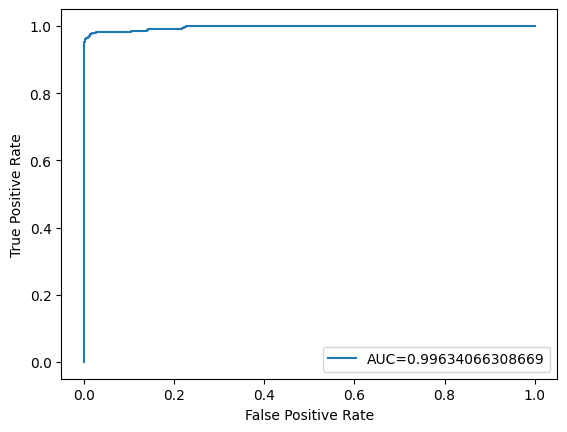

In [55]:
# ALWAYS reset X columns to the right order

cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

y_thing = y_test.to_numpy()
precision, recall, thresholds = precision_recall_curve(y_thing, best_xgboost.predict_proba(X_test)[::,1])
aaa = auc(recall, precision)
print("precision recall: " + str(aaa))

y_pred_proba = best_xgboost.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc_thing = roc_auc_score(y_test, y_pred_proba)

print(y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc_thing))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [53]:
cols_when_model_builds = best_xgboost.get_booster().feature_names
X_test=X_test[cols_when_model_builds]

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_xgboost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.955 (0.008)


In [54]:
cols_when_model_builds = best_gradBoost.feature_names_in_
X_test=X_test[cols_when_model_builds]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_gradBoost, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.953 (0.010)


In [51]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.915 (0.017)


In [ ]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(best_rF, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

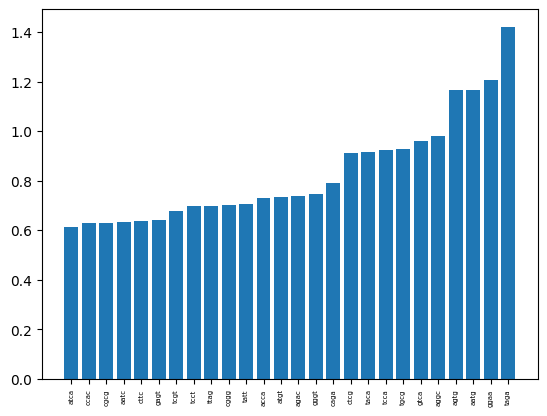

In [57]:
results = lrmodel.coef_[0]

l = zip([x for x in X_test.columns.values],results)
l = list(l)
res = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=5)

plt.bar([x[0] for x in res[230:]], [x[1] for x in res[230:]])
plt.show()

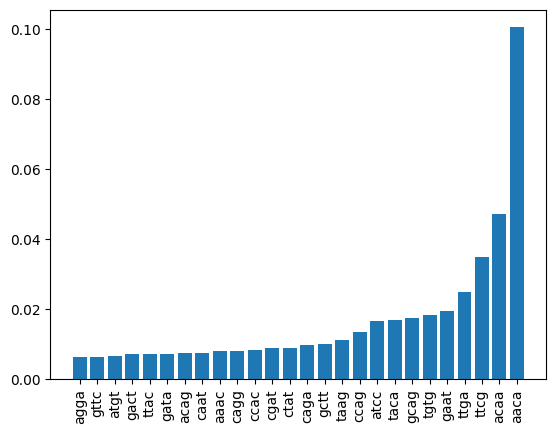

In [65]:
results = best_xgBoost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resxG = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resxG[230:]], [x[1] for x in resxG[230:]])
plt.show()

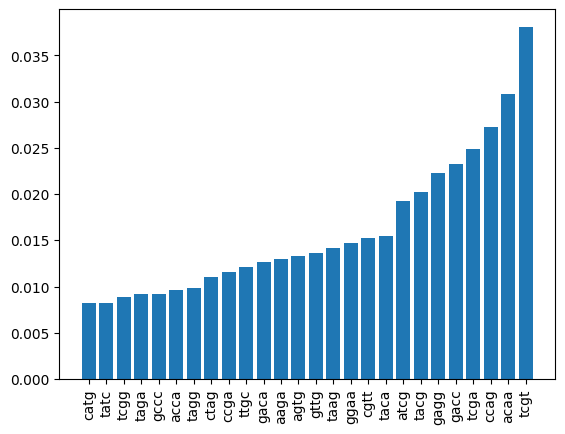

In [66]:
results = best_gradBoost.feature_importances_

l = zip([x for x in X_test.columns.values],results)
l = list(l)
resgB = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resgB[230:]], [x[1] for x in resgB[230:]])
plt.show()

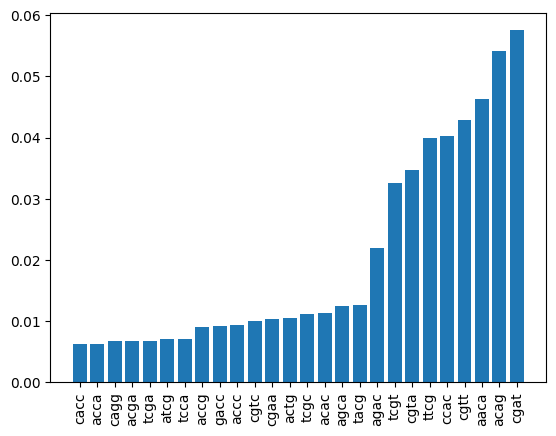

In [67]:
# get feature importances as a mean of feature importances PER tree
results = np.mean([est.steps[1][1].feature_importances_ for est in best_rF.estimators_], axis=0)


l = zip([x for x in X_test.columns.values],results)
l = list(l)
resrF = sorted(l, key= lambda x: x[1])

plt.xticks(rotation=90)
plt.tick_params(axis='x', which='major', labelsize=10)

plt.bar([x[0] for x in resrF[230:]], [x[1] for x in resrF[230:]])
plt.show()

In [84]:
max_bound = 3
for x in range(len(resrF)-bound+1):
    for i in range(max_bound):
        if resrF[x][0] == resgB[x+i][0]:  print("rF & gb bound", i, resrF[x], x)
        if resrF[x][0] == resxG[x+i][0]:  print("rF & xg bound", i, resrF[x], x)
        if resgB[x][0] == resxG[x+i][0]:  print("gb & xg bound", i, resgB[x], x)

rF & gb bound 1 ('cgcg', 0.0003015572826893574) 12
gb & xg bound 1 ('cgcc', 0.000778724560959825) 25
rF & gb bound 1 ('tatt', 0.0011150453509348468) 60
rF & gb bound 0 ('ctcg', 0.001601226302398424) 96
rF & xg bound 2 ('gctg', 0.0018774850802867136) 117
rF & gb bound 2 ('gaac', 0.0025670387790062968) 151
rF & xg bound 0 ('atca', 0.002846641046067592) 172
rF & xg bound 0 ('ccgc', 0.0029780245790469654) 178
gb & xg bound 2 ('aact', 0.003920699567262284) 186
rF & xg bound 2 ('cttg', 0.0035113486843959514) 195
gb & xg bound 1 ('taag', 0.014197001200931161) 244
gb & xg bound 1 ('taca', 0.015521578885323586) 247
rF & xg bound 2 ('aaca', 0.04631862605267052) 253
